In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pickle
import obspy
from scipy.signal import find_peaks
import os
import pandas as pd

from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit

import scipy.integrate


In [2]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [3]:
window = 2

In [4]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [5]:
# Define a sum of Gaussian functions
def multi_gaussian(x, *params):
    y = np.zeros_like(x)

    for i in range(0, len(params), 3):
        amp = params[i]
        mean = params[i+1]
        stddev = params[i+2]
        y += amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    return y

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


In [6]:
def plot_gaussians(popt, ax, time, momentrate, r_squared):
    if np.array_equal(popt, [0, 0, 0]):
        ax.plot(time, momentrate*1e18,
                    label='Data',
                    linestyle='-',
                    color='black',
                    zorder = 1)
        return
    num_gaussians = len(popt) // 3
    params = []
    for i in range(num_gaussians):
        if i < 10:
            ls = '--'
        else:
            ls = ':'
        amp = popt[0 + i*3]
        mean = popt[1 + i*3]
        stddev = popt[2 + i*3]
        params.append((amp, mean, stddev))
        x = time
        y = amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
        ax.plot(time, y*1e18,
                        #label=f'Gaussian {i+1}',
                        linestyle=ls,
                        zorder = 10)

    ax.plot(time, momentrate*1e18,
                        label='Data',
                        linestyle='-',
                        color='black')
    ax.plot(time, multi_gaussian(time, *popt)*1e18,
                            label=fr'Sum of {num_gaussians} Gaussians, $R^2$ = {r_squared:.3f}',
                            linestyle='-',
                            zorder = 1,
                            color='red')
    ax.legend()
    return

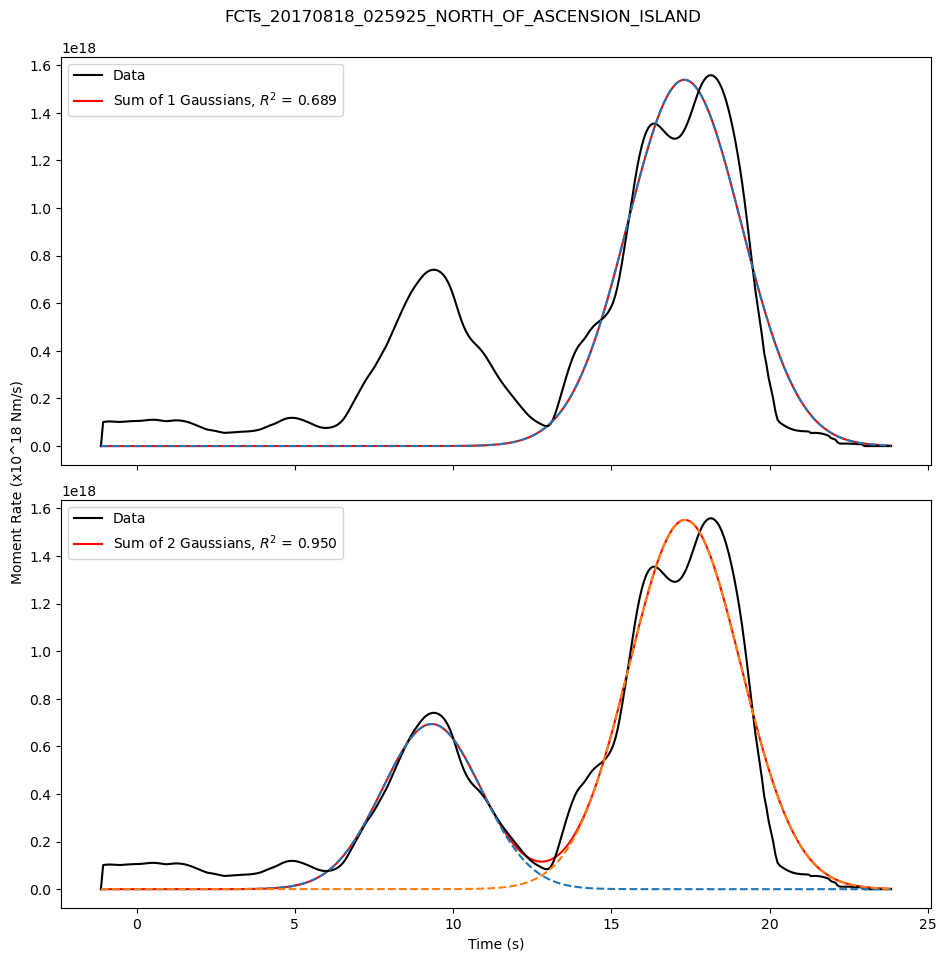

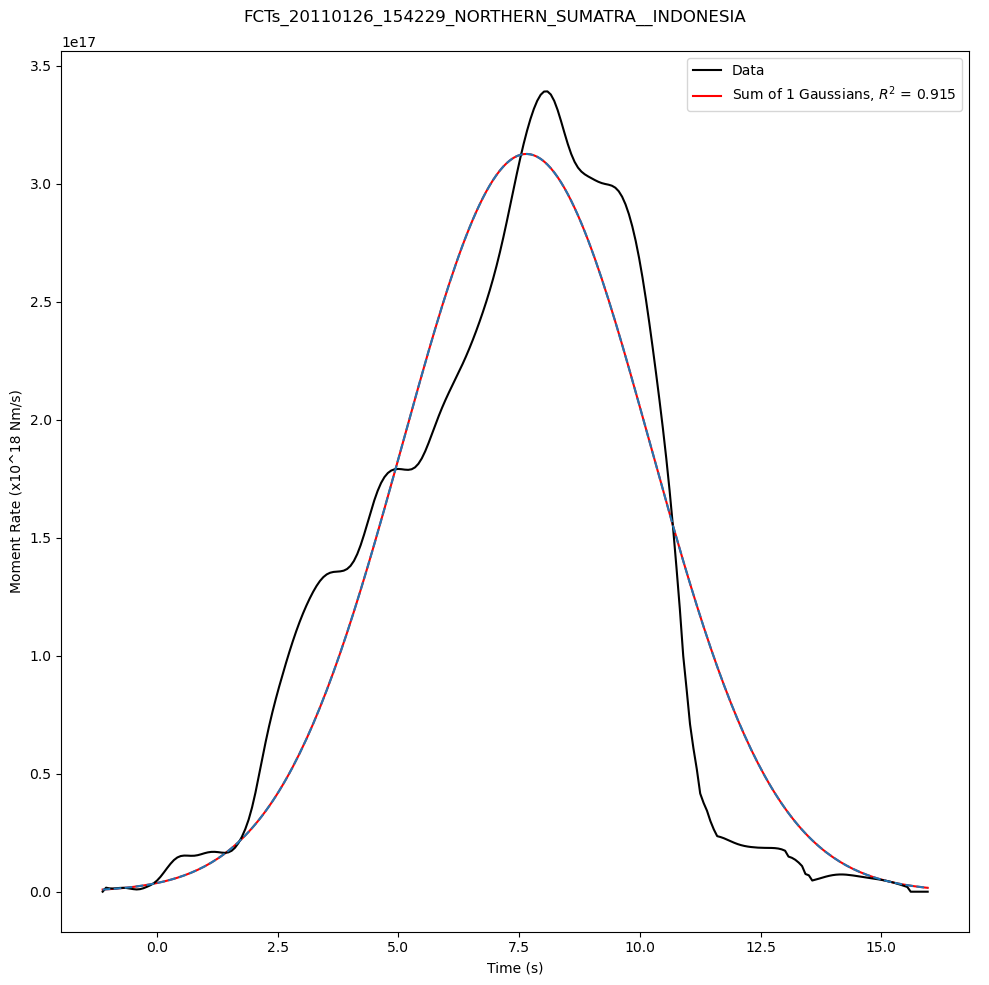

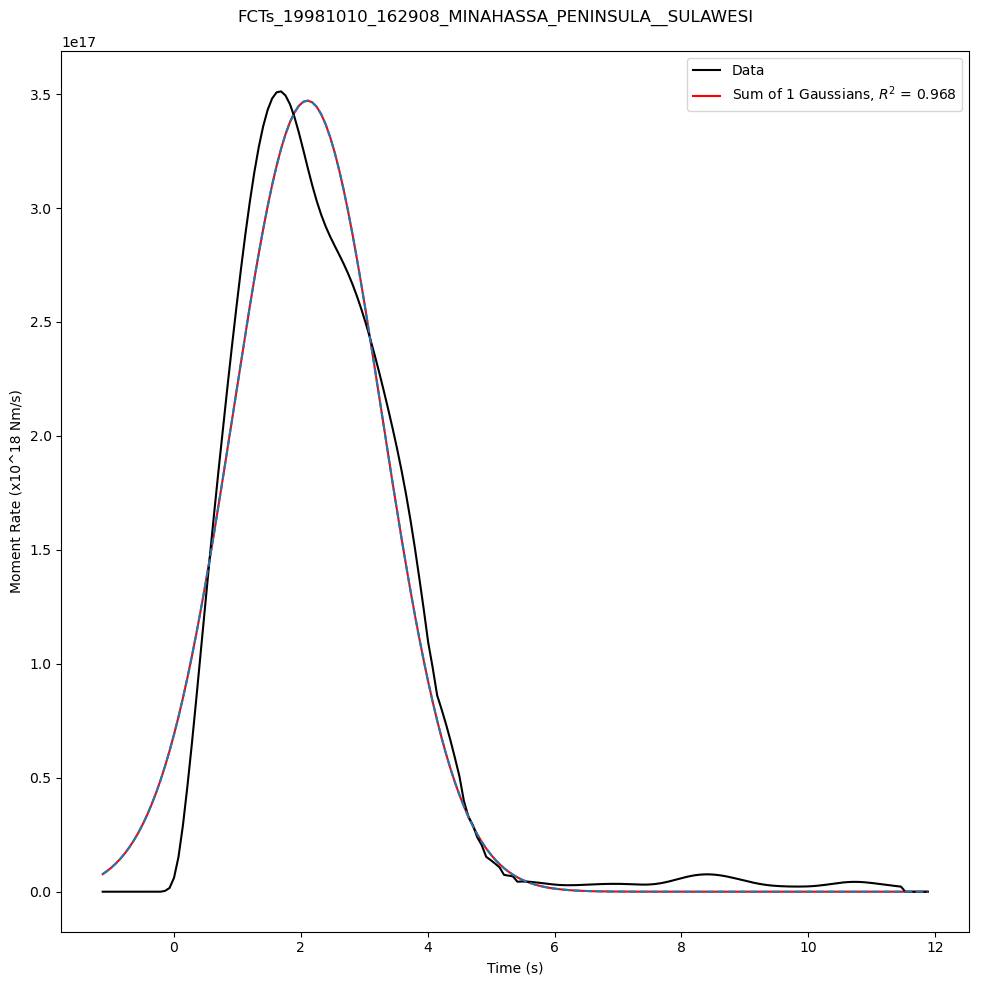

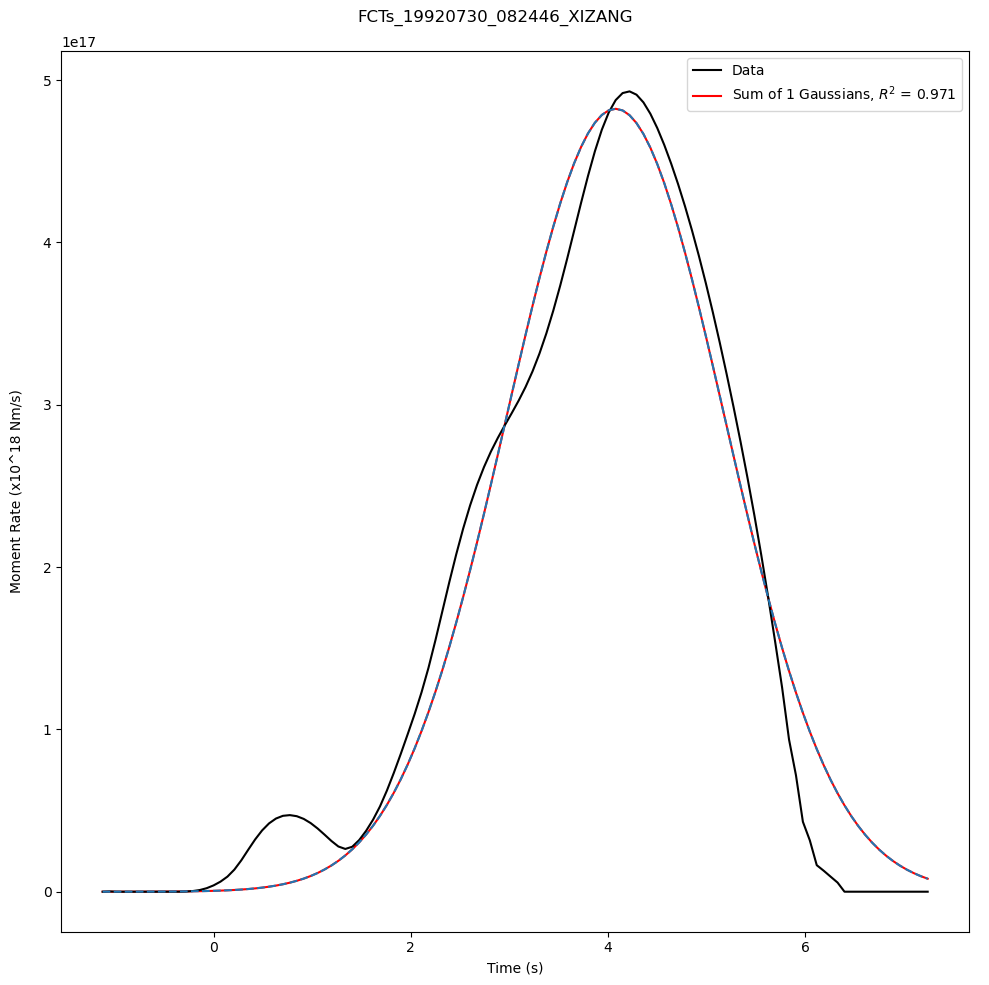

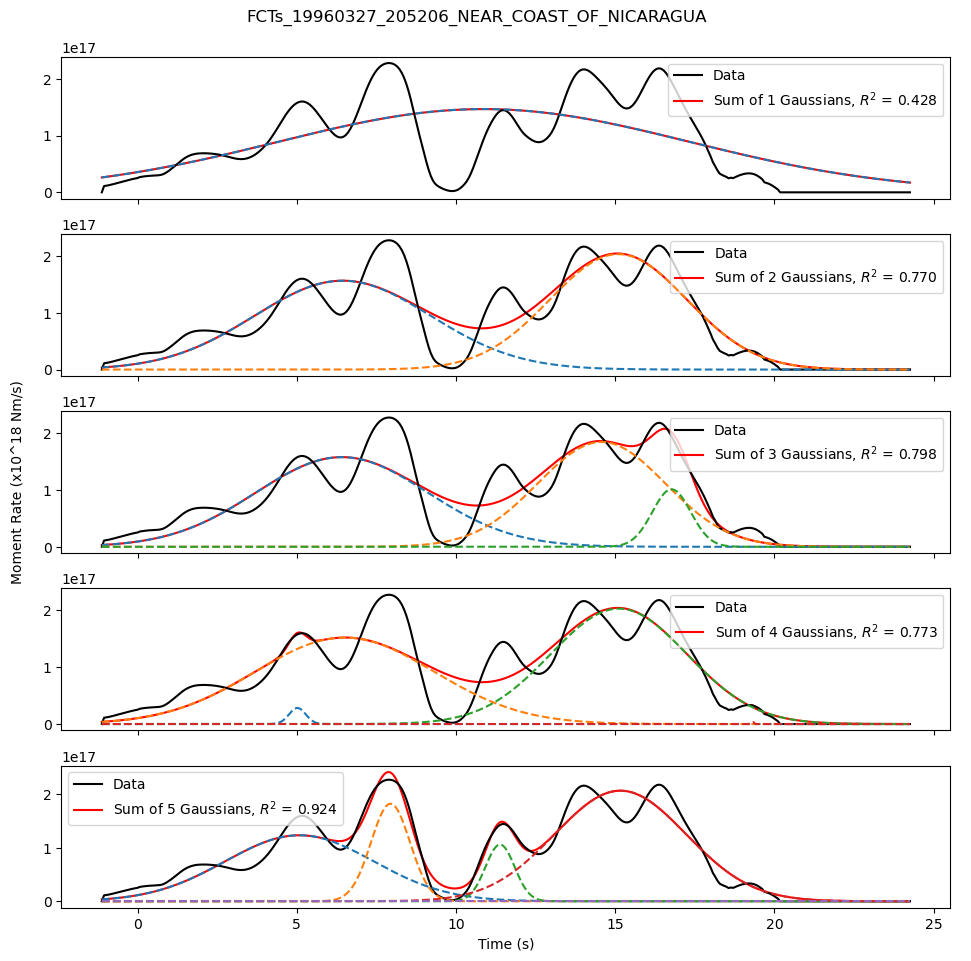

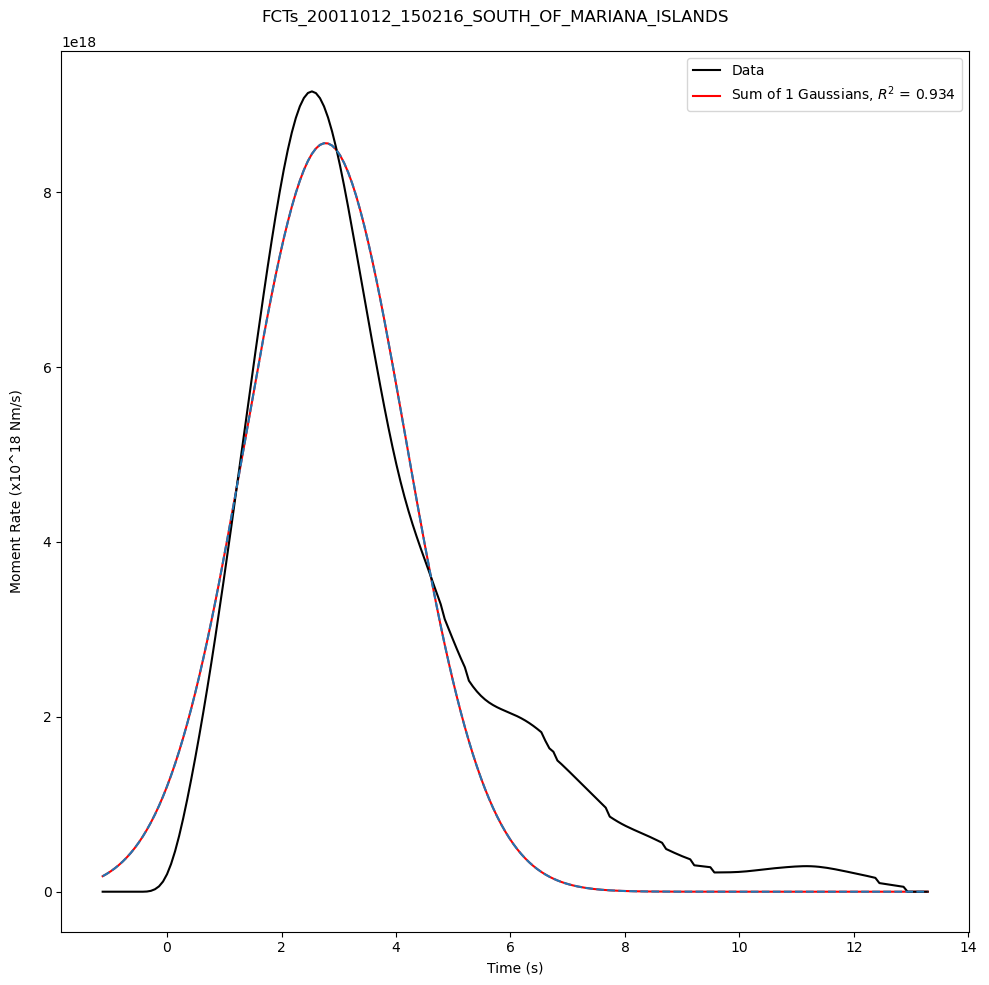

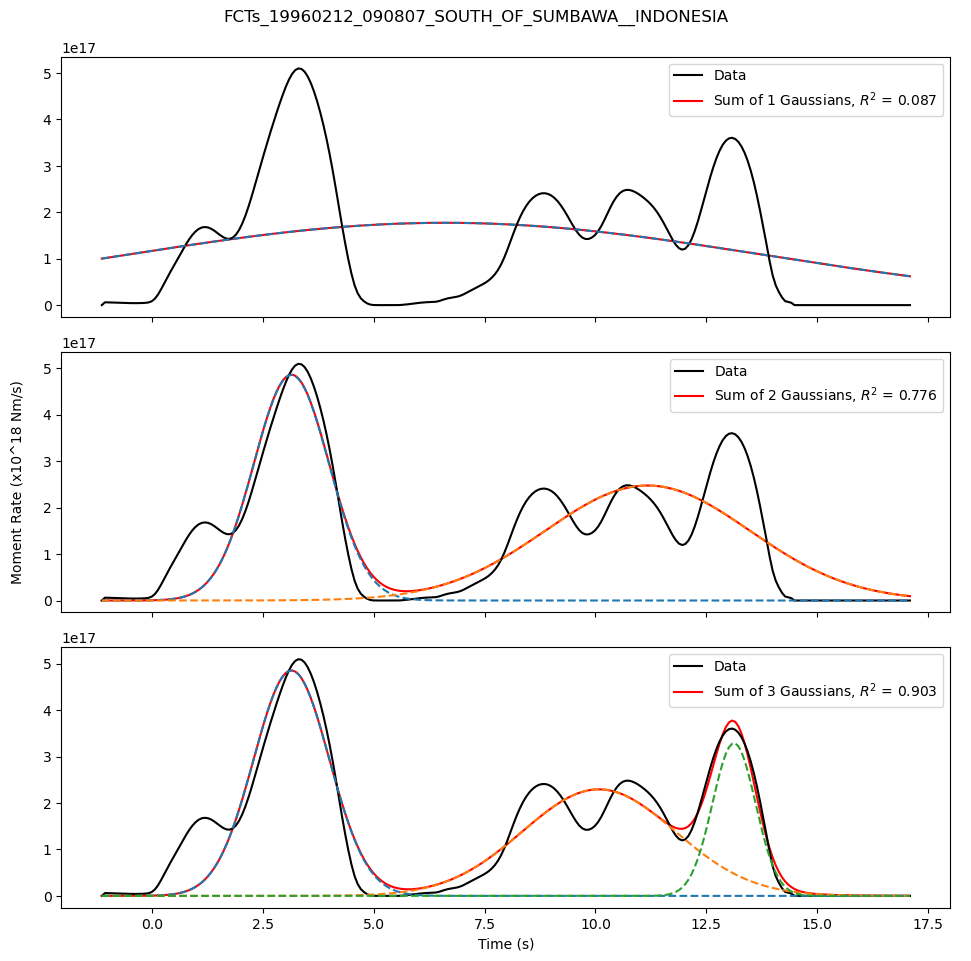

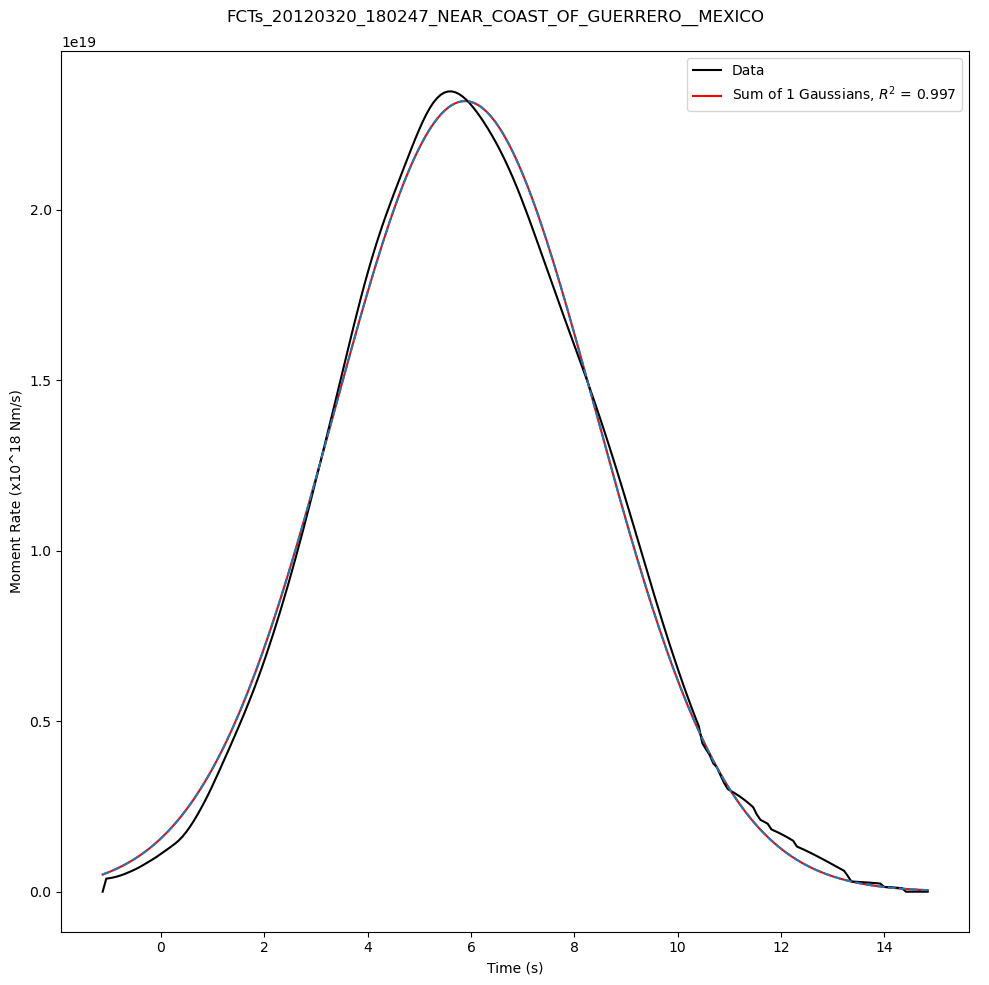

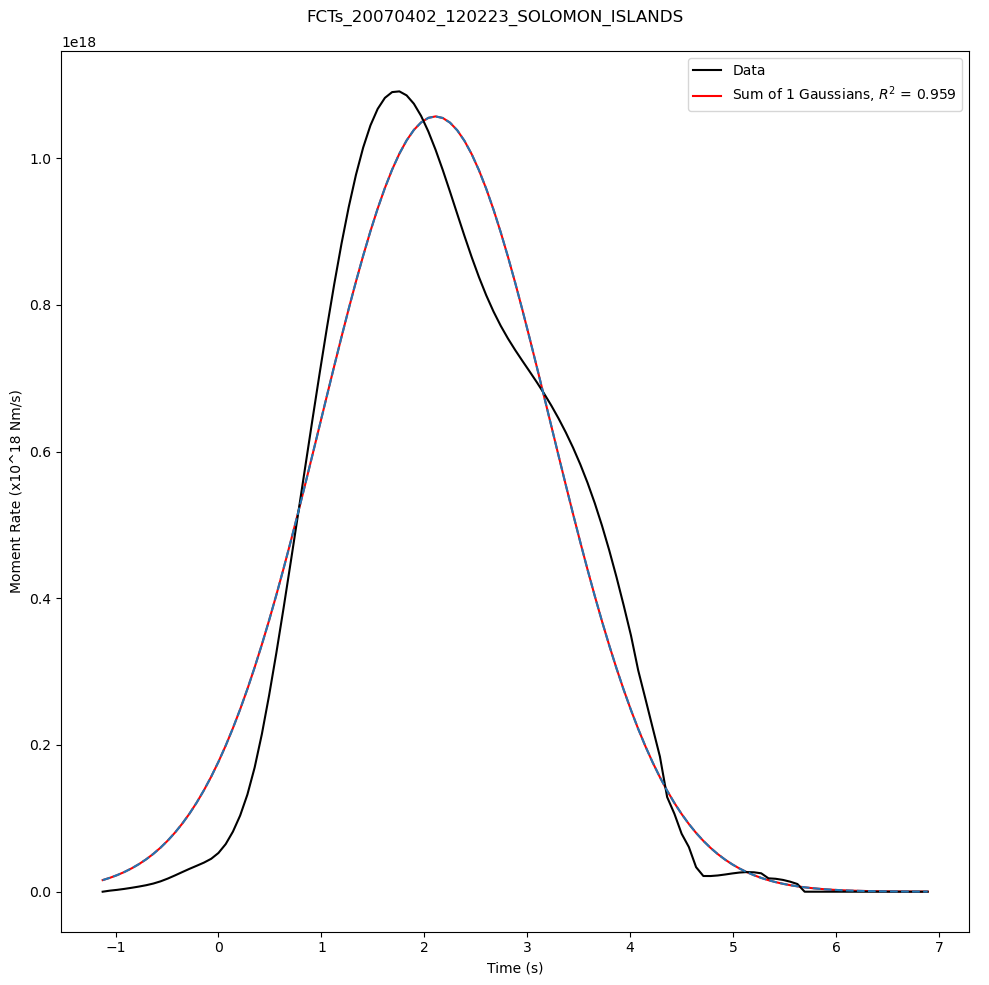

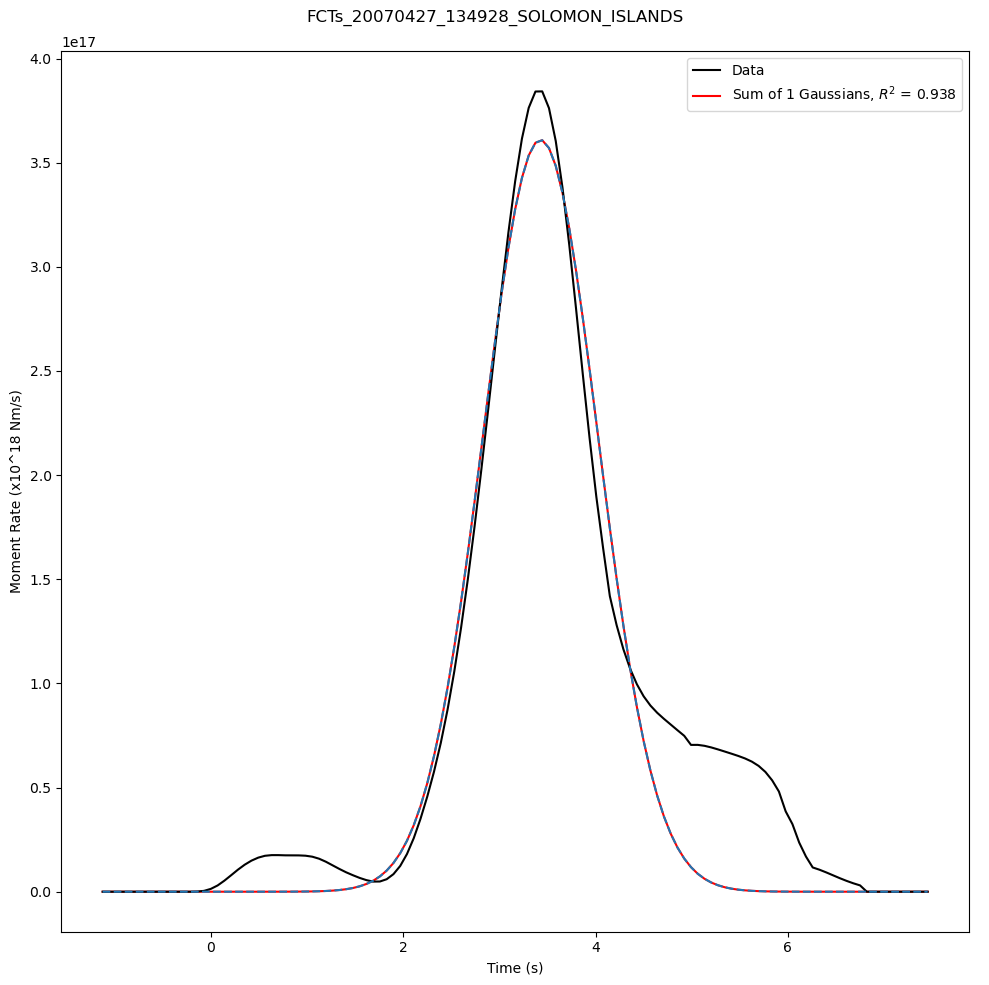

In [ ]:
smoothing_points = 1
r2_limit = 0.9

output_dir = f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/large_scale_peaks/R2_{r2_limit*10:02}/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec')[0:10]: #['FCTs_20170808_131949_GANSU__CHINA']:
    with open(f"/home/earthquakes1/homes/Rebecca/phd/stf/figures/large_scale_peaks/R2_{r2_limit*10:02}/{scardec_name}.txt", "w") as file:
        file.write(f"Processing {scardec_name}\n")
        popt_list = []
        r_squared_list = []
        db = combined[combined['scardec_name']==scardec_name]
        momentrate, time, db = get_stf(scardec_name, wanted_type = 'fctmoy')
        momentrate = momentrate/1e18
        momentrate = smooth(momentrate, smoothing_points)

        not_zero = np.where(momentrate > 0)[0]

        start = min(not_zero)
        end = max(not_zero)

        total_moment = scipy.integrate.simpson(momentrate[start:end], dx = time[1]-time[0])

        for gaussian_num in range(1, 11):
            file.write(f'Fitting {gaussian_num} Gaussians\n')
            initial_guess = []
            for i in range(gaussian_num):
                initial_guess.extend([1, (max(time)/(gaussian_num+1)) * (i+1), 1])

            bounds = ([0 if i % 3 == 0 else -np.inf for i in range(len(initial_guess))],
                      [np.inf for _ in range(len(initial_guess))])
            try:
                popt, pcov = curve_fit(multi_gaussian,
                                   time,
                                   momentrate,
                                   p0=initial_guess,
                                   bounds=bounds,
                                   maxfev=5000)
            except RuntimeError:
                r_squared_list.append(0)
                popt_list.append([0, 0, 0])
                print('Optimal parameters not found')
                continue

            num_gaussians = len(popt) // 3
            params = []
            for i in range(num_gaussians):
                amp = popt[i*3]
                mean = popt[i*3 + 1]
                stddev = popt[i*3 + 2]
                params.append((amp, mean, stddev))
                x = time
                y = amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
                file.write(f"Gaussian {i+1} - Amplitude: {amp}, Mean: {mean}, Standard Deviation: {stddev}\n")

            y_fit = multi_gaussian(time, *popt)
            residuals = momentrate - y_fit
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((momentrate - np.mean(momentrate))**2)
            r_squared = 1 - (ss_res / ss_tot)

            file.write(f'R-squared: {r_squared}\n')

            moment_gaussian = scipy.integrate.simpson(multi_gaussian(time, *popt), dx = time[1]-time[0])
            file.write(f'Proportion moment from Gaussian fit: {moment_gaussian/total_moment}\n')
            popt_list.append(popt)
            r_squared_list.append(r_squared)
            if r_squared > r2_limit:
                break

        if r_squared_list[-1] < r2_limit:
            print(scardec_name, f'r2 < {r2_limit}')
            file.write(f'!!!!!!!!!!!! R-squared < {r2_limit} !!!!!!!!!!!!!!!!!!!!\n')
            print(popt_list)

        # plotting
        if len(popt_list) == 1:
            fig, axs = plt.subplots(1,1, figsize=(10, 10), sharex=True)
            for i in range(0, len(popt_list)):
                popt = popt_list[i]
                plot_gaussians(popt, axs, time, momentrate, r_squared_list[0])
        elif len(popt_list) < 6:
            # print('in elif')
            fig, axs = plt.subplots(len(popt_list),1, figsize=(10, 10), sharex=True)
            for j in range(0, len(popt_list)):
                popt = popt_list[j]
                plot_gaussians(popt, axs[j], time, momentrate, r_squared_list[j])
        else:
            print(len(popt_list))
            print(scardec_name)
            if len(popt_list) % 2 == 0:
                print('in if')
                fig, axs = plt.subplots(((len(popt_list) + 1) // 2) + 1, 1, figsize=(10, 10), sharex=True)
            else:
                print('in else')
                fig, axs = plt.subplots(((len(popt_list)) // 2) + 1, 1, figsize=(10, 10), sharex=True)
            for j in range(0, len(popt_list), 2):
                popt = popt_list[j]
                plot_gaussians(popt, axs[j//2], time, momentrate, r_squared_list[j])
            # Plot the last element in popt_list
            if len(popt_list) % 2 == 0:
                popt = popt_list[-1]
                plot_gaussians(popt, axs[-1], time, momentrate, r_squared_list[j])


        if r_squared_list[-1] < r2_limit:
            plt.suptitle(f'{scardec_name} - R-squared < {r2_limit}')
        else:
            plt.suptitle(scardec_name)



        # Add a shared y-axis label by adding a subplot
        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.xlabel("Time (s)")
        plt.ylabel("Moment Rate (x10^18 Nm/s)")
        plt.tight_layout()
        plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/large_scale_peaks/R2_{r2_limit*10:02}/{scardec_name}.png')
        # if len(popt_list) > 4:
        plt.show()
        plt.close()
